# Install kaggle-environments

In [1]:
# 1. Enable Internet in the Kernel (Settings side pane)

# 2. Curl cache may need purged if v0.1.6 cannot be found (uncomment if needed). 
# !curl -X PURGE https://pypi.org/simple/kaggle-environments

# ConnectX environment was defined in v0.1.6
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1


# Create ConnectX Environment

In [2]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
from random import choice
from tqdm.notebook import tqdm
from collections import defaultdict



In [3]:
from kaggle_environments import evaluate, make, utils

env = make("connectx", debug=True)
env.render()

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+



In [4]:
config = env.configuration

In [5]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'negamax']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob
        
        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if random.uniform(0, 1) < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)

In [6]:
class QTable:
    def __init__(self, action_space):
        self.table = dict()
        self.action_space = action_space
        
    def add_item(self, state_key):
        self.table[state_key] = list(np.zeros(self.action_space.n))
        
    def __call__(self, state):
        board = state.board[:] # Get a copy
        board.append(state.mark)
        state_key = np.array(board).astype(str)
        state_key = hex(int(''.join(state_key), 3))[2:]
        if state_key not in self.table.keys():
            self.add_item(state_key)
        
        return self.table[state_key]



In [7]:
def print_board(board):
    for i in range(6):
        print(board[7*i:7*(i+1)])

In [8]:
env = ConnectX()
state = env.reset()
state, _, _, _ = env.step(0)
print_board(state.board)

[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]


In [9]:
board = state.board[:] # Get a copy
board.append(state.mark)
state_key = np.array(board).astype(str)
state_key = hex(int(''.join(state_key), 3))[2:]
# state.mark


In [10]:
q_table = QTable(env.action_space)


In [11]:
state = env.reset()
action = choice([c for c in range(env.action_space.n) if state.board[c] == 0])
next_state, _, _, _ = env.step(action)
q_table(next_state)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [12]:
env.action_space.n

7

In [13]:
def state_key(state):
    board = state.board[:] # Get a copy
    board.append(state.mark)
    state_key = np.array(board).astype(str)
    state_key = hex(int(''.join(state_key), 3))[2:]
    return state_key

In [14]:
class Q_learn:
    def __init__(self, lr, discount, eps, env):
        self.lr = lr
        self.discount = discount
        self.eps = eps
        self.env = env
        self.Q_table = defaultdict(lambda: defaultdict(lambda: 0))  

    def get_Q_value(self, state, action):
        return self.Q_table[state_key(state)][action]
    
    def set_Q_value(self, state, action, value):
        self.Q_table[state_key(state)][action] = value
        
    def best_value(self, state):
        possible_actions = [action for action in range(self.env.action_space.n) if state.board[action] == 0]
        try:
            return max([self.get_Q_value(state, action) for action in possible_actions])
        except:
            return -np.inf
    
    def best_action(self, state):
        row = [0, 1, 2, 3, 4, 5, 6]
        selected_items = []
        for j in range(self.env.action_space.n):
            if state.board[j] == 0:
                selected_items.append(row[j])
            else:
                selected_items.append(-1e7)
        action = int(np.argmax(selected_items))
        return action
    
    def do_action(self, state):
        possible_actions = [action for action in range(self.env.action_space.n) if state.board[action] == 0]
        
        if random.uniform(0, 1) < self.eps:
            action = choice([c for c in range(self.env.action_space.n) if state.board[c] == 0])
        else:
            action = self.best_action(state)
        return action
    
    def update_Q(self, state, action, next_state, reward):
        grad = self.lr * (reward + self.discount * self.best_value(next_state) \
                           - self.get_Q_value(state, action))
        current_Q = self.get_Q_value(state, action)
        self.set_Q_value(state, action, current_Q + grad)


In [16]:
def array_to_string(array):
        return ''.join([str(i) for i in array])

def check_reward(string, string_opn, mark):
    if 4*str(mark) in string:
        reward = 30
    else:
        if 4*str(3-mark) in string_opn:
            reward = 20
        else:
            if ('0'+str(mark)*3) in string or (str(mark)*3+'0') in string or \
            (str(mark)*2+'0'+str(mark)) in string or (str(mark)+'0'+str(mark)*2) in string:
                reward = 10
            else:
                if ('0'+str(mark)*3) in string_opn or (str(mark)*3+'0') in string_opn or \
                (str(mark)*2+'0'+str(mark)) in string_opn or (str(mark)+'0'+str(mark)*2) in string_opn:
                    reward = 0
                else:
                    if ('00'+str(mark)*2) in string or (str(mark)*2+'00') in string:
                        reward = -10
                    else:
                        reward = -20

    return reward


In [17]:
def reward_calculate(board, action):
    mark = board[42:][0]
    state = np.array(board[:42]).reshape(6, -1)
    state_opn = state.copy()
    assert action in range(7)
    assert np.count_nonzero(state[:, action]) < 6
    
    for row in range(6)[::-1]:
        if state[row, action] == 0:
            valid_row = row
            state[row, action] = mark
            break  

    state_opn[valid_row, action] = 3-mark

    #check vertical
    vertical = state[:, action]
    vertical_self = array_to_string(vertical)
    vertical_opn = vertical_self[:valid_row] + str(3-mark) + vertical_self[valid_row+1:]
    vertical_reward = check_reward(vertical_self, vertical_opn, mark)

    #check horizontal
    horizontal = state[valid_row, :]
    horizontal_self = array_to_string(horizontal)
    horizontal_opn = horizontal_self[:action] + str(3-mark) + horizontal_self[action+1:]
    horizontal_reward = check_reward(horizontal_self, horizontal_opn, mark)

    #check left diagonal
    if action - valid_row >= 0:
        left_self = array_to_string(state[:, action-valid_row:].diagonal(0))
        if len(left_self) < 4:
            left_reward = -30
        else:
            left_opn = array_to_string(state_opn[:, action-valid_row:].diagonal(0))
            left_reward = check_reward(left_self, left_opn, mark)
    else:
        left_self = array_to_string(state[valid_row-action:,:].diagonal(0))
        if len(left_self) < 4:
            left_reward = -30
        else:
            left_opn = array_to_string(state_opn[:, action-valid_row+1:].diagonal(0))
            left_reward = check_reward(left_self, left_opn, mark)

    #check right diagonal        
    if action + valid_row < 7:
        right_self = array_to_string(state[:, :action+valid_row+1][:, ::-1].diagonal(0))
        if len(right_self) < 4:
            right_reward = -30
        else:
            right_opn = array_to_string(state_opn[:, :action+valid_row+1][:, ::-1].diagonal(0))
            right_reward = check_reward(right_self, right_opn, mark)
    else:
        right_self = array_to_string(state[action+valid_row-6:, :][:, ::-1].diagonal(0))
        if len(right_self) < 4:
            right_reward = -30
        else:
            right_opn = array_to_string(state_opn[action+valid_row-6:, :][:, ::-1].diagonal(0))
            right_reward = check_reward(right_self, right_opn, mark)
    
    reward = max(vertical_reward, horizontal_reward, left_reward, right_reward)
    
    # check if next move opponent won
    if reward < 20:
        if (state[:, action] == 0).any():
            valid_row -= 1
            state_opt_next = state.copy()
            state_opt_next[valid_row, action] = 3-mark

            #check horizontal
            horizontal = array_to_string(state_opt_next[valid_row, :])
            if 4*str(3-mark) in horizontal:
                return -50

            #check left diagonal
            if action - valid_row >= 0:
                left_self = array_to_string(state_opt_next[:, action-valid_row:].diagonal(0))
            else:
                left_self = array_to_string(state_opt_next[valid_row-action:,:].diagonal(0))            
            if 4*str(3-mark) in left_self:
                return -50

            #check right diagonal
            if action + valid_row < 7:
                right_self = array_to_string(state_opt_next[:, :action+valid_row+1][:, ::-1].diagonal(0))
            else:
                right_self = array_to_string(state_opt_next[action+valid_row-6:, :][:, ::-1].diagonal(0))
            if 4*str(3-mark) in right_self:
                return -50
        
    return reward

In [19]:
env = ConnectX()
q_learn = Q_learn(0.1, 0.9, 0.99, env)
alpha = 0.1
gamma = 0.9
epsilon = 0.99
min_epsilon = 0.1

episodes = 10000

alpha_decay_step = 1000
alpha_decay_rate = 0.9
epsilon_decay_rate = 0.9999


all_epochs = []
all_total_rewards = []
all_avg_rewards = [] # Last 100 steps
all_qtable_rows = []
all_epsilons = []

for i in tqdm(range(episodes)):
    state = env.reset()
    
    q_learn.eps = max(min_epsilon, q_learn.eps * epsilon_decay_rate)
    epochs, total_rewards = 0, 0
    done = False
    
    while not done:
        
        action = q_learn.do_action(state)
        
        next_state, reward, done, info = env.step(int(action))
        possible_actions = [action for action in range(env.action_space.n) if state.board[action] == 0]
        if len(possible_actions) == 0:
            break

        # Apply new rules
        board = state.board
        board.append(state.mark)
        reward = reward_calculate(state.board, action)
            
        q_learn.update_Q(state, action, next_state, reward)

        state = next_state
        epochs += 1
        total_rewards += reward


    all_epochs.append(epochs)
    all_total_rewards.append(total_rewards)
    avg_rewards = np.mean(all_total_rewards[max(0, i-100):(i+1)])
    all_avg_rewards.append(avg_rewards)
    all_epsilons.append(epsilon)

    if (i+1) % alpha_decay_step == 0:
        alpha *= alpha_decay_rate


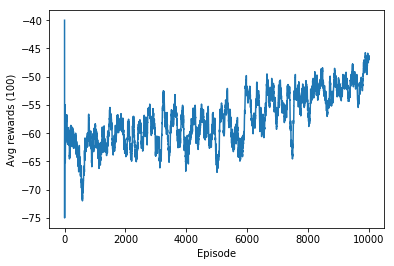

In [20]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()


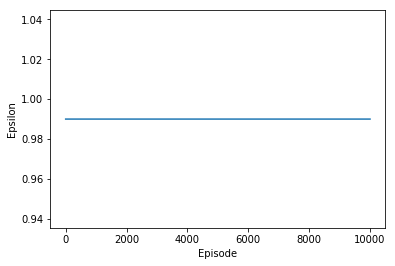

In [21]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()


In [22]:
tmp_dict_q_table = q_learn.Q_table.copy()
dict_q_table = dict()

for k in tmp_dict_q_table:
    if np.count_nonzero(tmp_dict_q_table[k]) > 0:
        dict_q_table[k] = int(np.argmax(tmp_dict_q_table[k]))


In [23]:
my_agent = '''def my_agent(observation, configuration):
    from random import choice

    q_table = ''' \
    + str(dict_q_table).replace(' ', '') \
    + '''

    board = observation.board[:]
    board.append(observation.mark)
    state_key = list(map(str, board))
    state_key = hex(int(''.join(state_key), 3))[2:]

    if state_key not in q_table.keys():
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    action = q_table[state_key]

    if observation.board[action] != 0:
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    return action
    '''


In [24]:
with open('submission.py', 'w') as f:
    f.write(my_agent)

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [25]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("/kaggle/working/submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

Success!


# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.